In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scvi.model import CondSCVI, DestVI

sc.set_figure_params(figsize=(4, 4), frameon=False)

%load_ext lab_black

Global seed set to 0


In [2]:
root = pathlib.Path("/Users/giovanni.palla/Datasets/advomics")
sc_adata = sc.read(root / "GSE156793_fetal_heart_scNym_RAW_ctl201119.h5ad")
sc_adata.var_names_make_unique()
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()
sc_adata = sc_adata[
    sc_adata.obs.Main_cluster_name != "Erythroblasts"
].copy()  # remove Erythroblasts cause they are too few
sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3']
  warnings.warn(


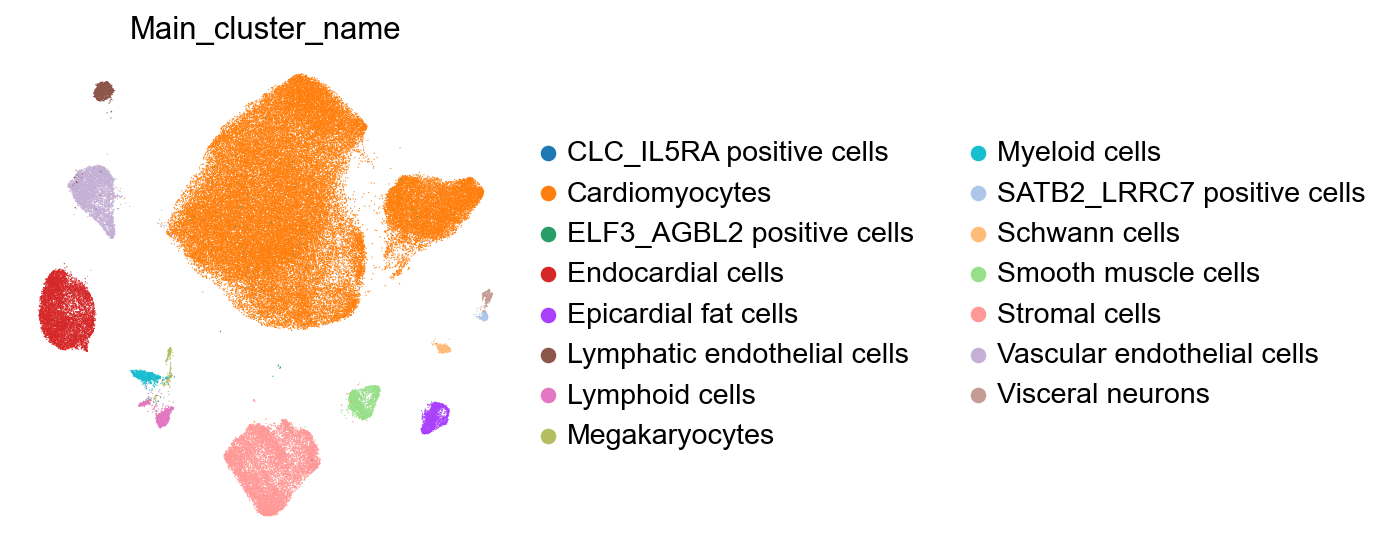

In [3]:
sc.pl.umap(sc_adata, color="Main_cluster_name")

In [4]:
sc_adata.layers["counts"]

<96664x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 2851585 stored elements in Compressed Sparse Row format>

In [5]:
st_adata = sc.read(root / "spatial_adata/V10F24-105_A1.h5ad")
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


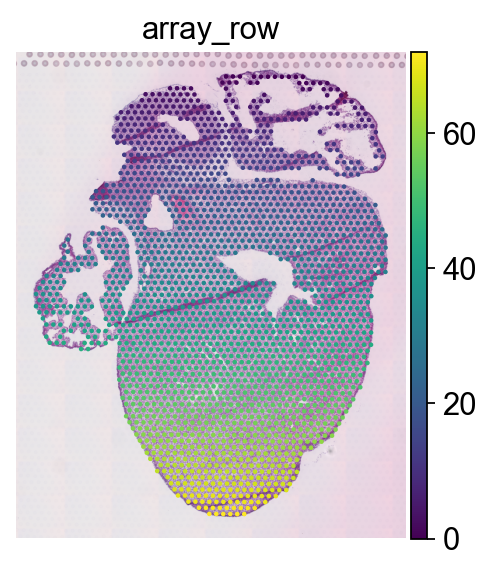

In [6]:
sc.pl.spatial(st_adata, color="array_row")

In [7]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

In [8]:
from scvi.external import RNAStereoscope, SpatialStereoscope

RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

In [ ]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs = 100)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/100:   0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

In [7]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

In [8]:
sc_model = CondSCVI(sc_adata, weight_obs=True)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.4.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'Main_cluster_name', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 96664 │
│      n_vars      │ 1287  │
│     n_labels     │  15   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Main_cluster_name'] │  CLC_IL5RA positive cells   │          0          │
│                                │       Cardiomyocytes        │          1          │
│                                │  ELF3_AGBL2 positive cells  │          2          │
│                                │      Endocardial cells      │          3          │
│                                │    Epicardial fat cells     │          4          │
│                                │ Lymphatic endothelial cells │          5          │
│                                │       Lymphoid cells        │          6          │
│                                │       Megakaryocytes        │          7          │
│                                │        Myeloid cells        │          8          │
│                                │ SATB2_LRRC7 positive cells  │          9          │
│                                │        Schwann cells        │         10          │
│                                │     Smooth muscle cells     │         11          │
│                                │        Stromal cells        │         12          │
│                                │ Vascular endothelial cells  │         13          │
│                                │      Visceral neurons       │         14          │
└────────────────────────────────┴─────────────────────────────┴─────────────────────┘

In [9]:
sc_adata.obs.Main_cluster_name.value_counts()

Cardiomyocytes                 64691
Stromal cells                  10583
Endocardial cells               7347
Vascular endothelial cells      4806
Smooth muscle cells             1984
Epicardial fat cells            1872
Lymphoid cells                  1326
Lymphatic endothelial cells     1242
Myeloid cells                   1019
Schwann cells                    526
Megakaryocytes                   353
Visceral neurons                 347
SATB2_LRRC7 positive cells       311
ELF3_AGBL2 positive cells        159
CLC_IL5RA positive cells          98
Name: Main_cluster_name, dtype: int64

In [ ]:
sc_model.train(
    max_epochs=250,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/250:   0%|                                                                                                                                                         | 0/250 [00:00<?, ?it/s]

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)